## **Lightweight Implementation of Byte Latent Transformer**
Here we implement a charcter-level BLT (Byte Latent Transformer) model from scatch under 500 lines of code. The Byte Latent Transformer architecture is a tokenizer-free architecture that learns from raw byte data, recently introduced in this [paper](https://dl.fbaipublicfiles.com/blt/BLT__Patches_Scale_Better_Than_Tokens.pdf) by meta.

BLT processes raw bytes instead of tokens, using dynamic patches based on entropy. The architecture consists of lightweight local encoder, large latent transformer, and lightweight local decoder. This implementation tries to follow the paper as close as possible with simplified versions of each module in the architecture. Below shows illustrations from the paper.


<img src="assets/blt.jpeg" />
<img src="assets/blt2.png" />

Using device: cuda

Hyperparameters:
n_embd: 128
n_head: 2
n_layers_encoder: 2
n_layers_latent: 4
n_layers_decoder: 2
dropout: 0.1
vocab_size: 256
patch_size: 4
Total bytes: 1,115,394
Block size: 1024 bytes
Batch size: 8 sequences
Number of iterations: 2000

Training...
step 1/2000 | loss 6.0808 | 85166.91 bytes/s | bits-per-byte 8.7727 | 2048 patches
step 2/2000 | loss 5.0191 | 85532.09 bytes/s | bits-per-byte 8.0069 | 4096 patches
step 3/2000 | loss 4.3742 | 94362.91 bytes/s | bits-per-byte 7.4414 | 6144 patches
step 4/2000 | loss 4.1207 | 101116.05 bytes/s | bits-per-byte 7.0673 | 8192 patches
step 5/2000 | loss 3.8360 | 106534.23 bytes/s | bits-per-byte 6.7607 | 10240 patches
step 6/2000 | loss 3.7044 | 109588.32 bytes/s | bits-per-byte 6.5246 | 12288 patches
step 7/2000 | loss 3.6626 | 107635.68 bytes/s | bits-per-byte 6.3474 | 14336 patches
step 8/2000 | loss 3.5600 | 108066.74 bytes/s | bits-per-byte 6.1960 | 16384 patches
step 9/2000 | loss 3.5207 | 108156.17 bytes/s | bits-per

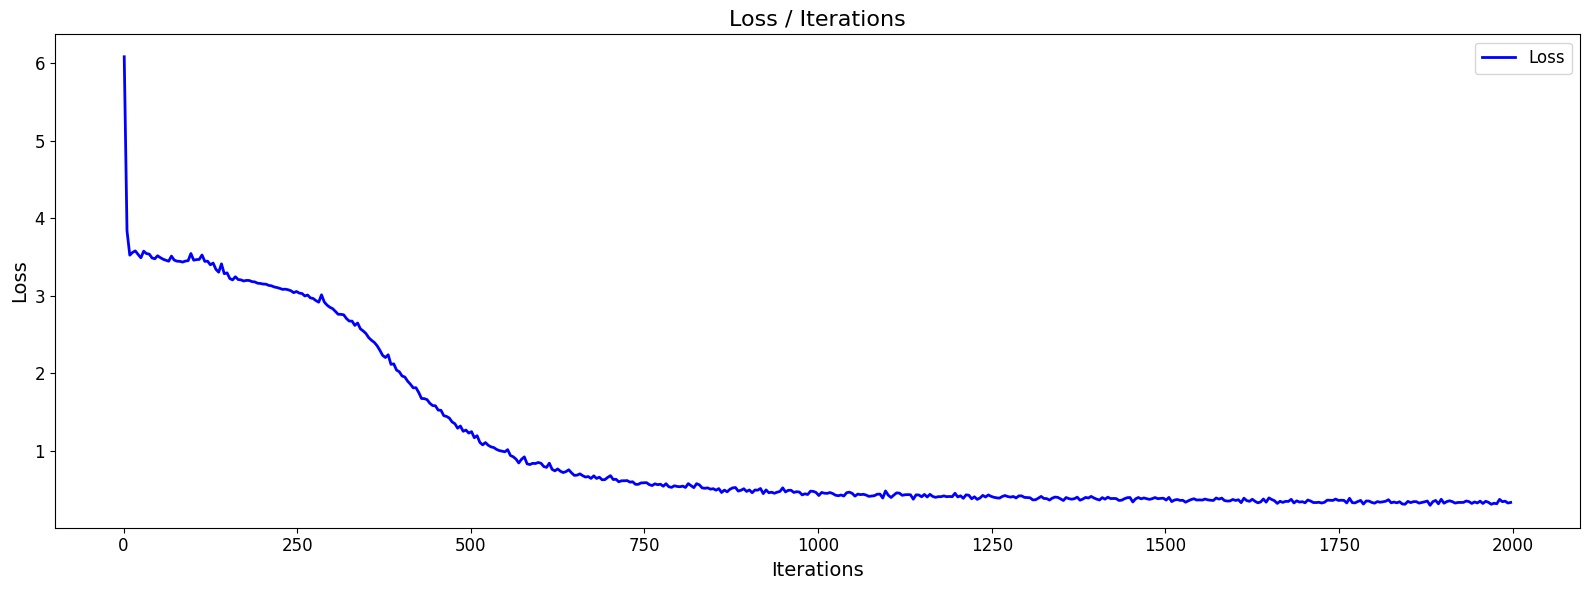

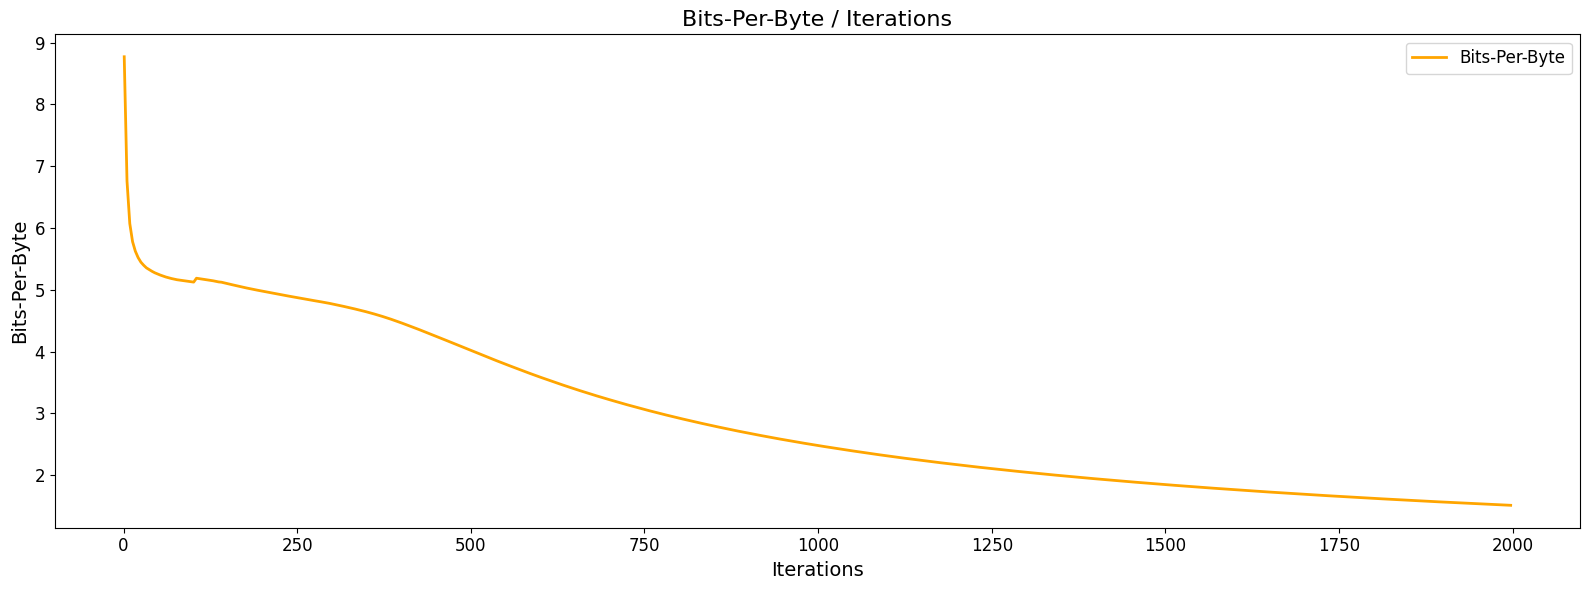

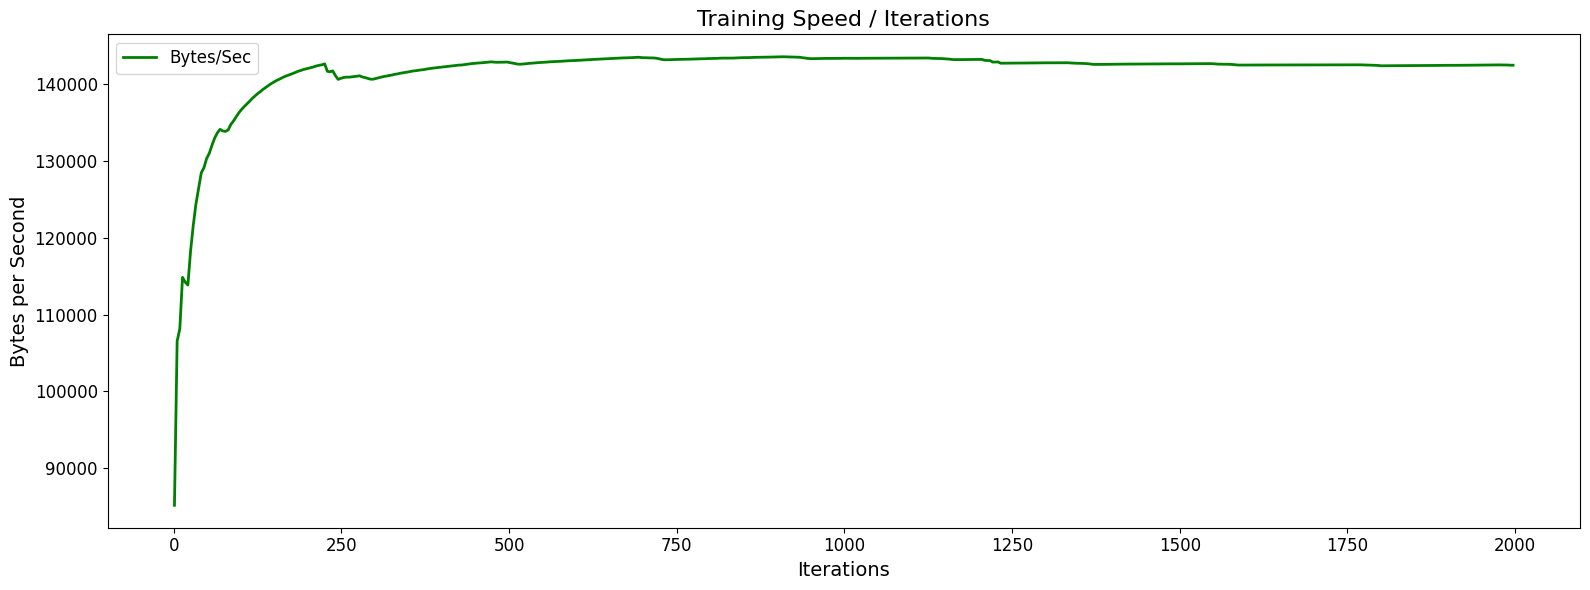

Once upon a at hap\aoply arcacoaad aroraaking aemmy arname.
Commaned hand ararnedoucbodigreesetake her;
Pardon me, imavarcelion.
Look?
ed waririt is lice,
SaysShe evils!
You conequal and are
Play of maid itwere
Proman old aries
Cined plocksain of charge. Pray haach;
GLouncemabboom
Sree
Shed a acoal, well, am ELIO:
Grayemary wiaHEven yougee hapbed ring me you hashrou
Sgher apuppings had thunder:
Clarence restible; into refer, PELI'LDAne doboUpey Lord Nortumbl wing;
Plausiege.
HO, each and MESExec again


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 8
block_size = 1024
patch_size = 4  # Number of bytes per patch
num_iters = 2000  # Number of training iterations
learning_rate = 1e-3
n_embd = 128      # Embedding dimension
n_head = 2        # Number of attention heads
n_layers_encoder = 2  # lE << lG # Number of layers in the encoder
n_layers_latent = 4   # lG # Number of layers in the latent transformer
n_layers_decoder = 2  # lD << lG # Number of layers in the decoder
dropout = 0.1
vocab_size = 256  # Number of unique bytes
hash_sizes = range(3, 6)  # n-gram sizes
hash_table_size = 50000  # Size of each hash table

class LayerNorm(nn.Module):
    """Custom Layer Normalization."""
    def __init__(self, ndim, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class Block(nn.Module):
    """Transformer Block with LayerNorm, Attention, and MLP."""
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1 = LayerNorm(n_embd)
        self.attn = nn.MultiheadAttention(embed_dim=n_embd, num_heads=n_head, dropout=dropout, batch_first=True)
        self.ln2 = LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attn_out, _ = self.attn(self.ln1(x), self.ln1(x), self.ln1(x))
        x = x + attn_out
        x = x + self.mlp(self.ln2(x))
        return x

class CrossAttentionLayer(nn.Module):
    """Cross Attention Layer for Encoder and Decoder."""
    def __init__(self, query_dim, key_dim, n_head, dropout):
        super().__init__()
        self.ln_q = LayerNorm(query_dim)
        self.ln_kv = LayerNorm(key_dim)
        self.attn = nn.MultiheadAttention(embed_dim=query_dim, num_heads=n_head, dropout=dropout, batch_first=True)
        self.proj = nn.Linear(query_dim, query_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        query = self.ln_q(query)
        key = self.ln_kv(key)
        value = self.ln_kv(value)
        attn_out, _ = self.attn(query, key, value)
        attn_out = self.proj(attn_out)
        attn_out = self.dropout(attn_out)
        return query + attn_out

class HashNGramEmbedding(nn.Module):
    """Hash n-gram Embeddings."""
    def __init__(self, hash_sizes, hash_table_size, n_embd):
        super().__init__()
        self.hash_sizes = hash_sizes
        self.hash_table_size = hash_table_size
        self.n_embd = n_embd
        self.hash_embeddings = nn.ModuleDict({
            f"hash_{n}": nn.Embedding(hash_table_size, n_embd) for n in hash_sizes
        })

    def forward(self, x):
        B, T = x.shape
        embeddings = torch.zeros(B, T, self.n_embd, device=x.device)
        for n in self.hash_sizes:
            if T < n:
                continue
            # Extract n-grams
            ngrams = x.unfold(1, n, 1)  # [B, T - n +1, n]
            # Compute hash
            hashes = self.roll_poly_hash(ngrams)
            hashes = hashes % self.hash_table_size
            # Lookup embeddings
            hash_emb = self.hash_embeddings[f"hash_{n}"](hashes)  # [B, T - n +1, n_embd]
            # Scatter add
            embeddings[:, n-1:T, :] += hash_emb
        # Normalize
        embeddings = embeddings / len(self.hash_sizes)
        return embeddings  # [B, T, n_embd]

    def roll_poly_hash(self, ngrams):
        """Simple polynomial rolling hash."""
        base = 257
        hash_val = torch.zeros(ngrams.size(0), ngrams.size(1), device=ngrams.device, dtype=torch.long)
        for i in range(ngrams.size(2)):
            hash_val = (hash_val * base + ngrams[:, :, i].long()) % (2**32)
        return hash_val

class LocalEncoder(nn.Module):
    """Local Encoder that encodes input bytes into patch representations."""
    def __init__(self, vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, lE):
        super().__init__()
        self.patch_size = patch_size
        self.n_embd = n_embd
        self.byte_embedding = nn.Embedding(vocab_size, n_embd)
        self.hash_ngram = HashNGramEmbedding(hash_sizes, hash_table_size, n_embd)
        self.transformer_blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(lE)])
        self.cross_attn = CrossAttentionLayer(n_embd, n_embd, n_head, dropout)
        self.ln = LayerNorm(n_embd)

    def forward(self, x):
        B, T = x.shape
        # Byte Embedding
        x_emb = self.byte_embedding(x)  # [B, T, C]
        # Hash n-gram Embedding
        hash_emb = self.hash_ngram(x)  # [B, T, C]
        x_emb = x_emb + hash_emb  # [B, T, C]
        # Transformer Layers
        for block in self.transformer_blocks:
            x_emb = block(x_emb)
        # Cross-Attention to form patches
        # Assume patches are non-overlapping
        # Pad if necessary
        if T % self.patch_size != 0:
            pad_len = self.patch_size - (T % self.patch_size)
            pad = torch.zeros((B, pad_len), dtype=x.dtype, device=x.device).long()
            pad_emb = self.byte_embedding(pad)  # [B, pad_len, C]
            pad_emb += self.hash_ngram(pad)  # Incorporate hash embeddings
            x_emb = torch.cat([x_emb, pad_emb], dim=1)  # [B, T + pad_len, C]
            T += pad_len
        # Reshape and pool to create patch representations
        patches = x_emb.view(B, T // self.patch_size, self.patch_size, self.n_embd).mean(dim=2)  # [B, N_patches, C]
        patches = self.cross_attn(patches, x_emb, x_emb)  # [B, N_patches, C]
        patches = self.ln(patches)
        return patches  # [B, N_patches, C]

class LatentTransformer(nn.Module):
    """Latent Transformer over patch representations."""
    def __init__(self, n_embd, n_head, n_layers, dropout):
        super().__init__()
        self.blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(n_layers)])
        self.ln_f = LayerNorm(n_embd)

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return self.ln_f(x)

class LocalDecoder(nn.Module):
    """Local Decoder to decode the next patch of bytes."""
    def __init__(self, vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, lD):
        super().__init__()
        self.patch_size = patch_size
        self.vocab_size = vocab_size
        self.hash_ngram = HashNGramEmbedding(hash_sizes, hash_table_size, n_embd)
        self.cross_attn = CrossAttentionLayer(n_embd, n_embd, n_head, dropout)
        self.transformer_blocks = nn.ModuleList([Block(n_embd, n_head, dropout) for _ in range(lD)])
        self.byte_proj = nn.Linear(n_embd, patch_size * vocab_size)
        self.ln = LayerNorm(vocab_size)  # Corrected to vocab_size

    def forward(self, x, patches):
        # Cross-Attention: bytes query patches
        x = self.cross_attn(x, patches, patches)  # [B, T_patches, C]
        # Transformer Blocks
        for block in self.transformer_blocks:
            x = block(x)
        # Project to bytes
        x = self.byte_proj(x)  # [B, T_patches, patch_size * vocab_size]
        # Reshape to [B, T, vocab_size]
        B, T_patches, _ = x.shape
        x = x.view(B, T_patches * self.patch_size, self.vocab_size)  # [B, T, vocab_size]
        x = self.ln(x)  # [B, T, vocab_size]
        return x  # [B, T, vocab_size]

class ByteLatentTransformer(nn.Module):
    """Byte Latent Transformer combining encoder, transformer, and decoder."""
    def __init__(self, vocab_size, n_embd, n_head, n_layers_encoder, n_layers_latent, n_layers_decoder, dropout, patch_size, hash_sizes, hash_table_size, block_size):
        super().__init__()
        self.local_encoder = LocalEncoder(vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, n_layers_encoder)
        self.latent_transformer = LatentTransformer(n_embd, n_head, n_layers_latent, dropout)
        self.local_decoder = LocalDecoder(vocab_size, n_embd, patch_size, hash_sizes, hash_table_size, n_head, dropout, n_layers_decoder)
        self.pos_embedding = nn.Parameter(torch.zeros(1, block_size // patch_size, n_embd))
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        # Encode bytes to patches
        patches = self.local_encoder(x)  # [B, N_patches, C]
        # Add positional embeddings
        patches = patches + self.pos_embedding[:, :patches.size(1), :]  # [B, N_patches, C]
        # Transform patches
        transformed_patches = self.latent_transformer(patches)  # [B, N_patches, C]
        # Decode patches to bytes
        logits = self.local_decoder(transformed_patches, patches)  # [B, T, vocab_size]
        if targets is not None:
            B, T, _ = logits.shape
            loss = F.cross_entropy(logits.view(B * T, -1), targets.view(-1))
        else:
            loss = None
        return logits, loss

class PrepData:
    """Dataset handling byte-level text data."""
    def __init__(self, text, block_size, patch_size):
        self.data = torch.frombuffer(text.encode('utf-8'), dtype=torch.uint8)
        self.block_size = block_size
        self.patch_size = patch_size
        assert self.block_size % self.patch_size == 0, "block_size must be divisible by patch_size."

    def __len__(self):
        return len(self.data) - self.block_size - self.patch_size + 1

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + self.patch_size]
        x = chunk[:self.block_size].long()
        y = chunk[1:self.block_size + 1].long()  # Changed to next byte
        return x, y

def bits_per_byte(loss):
    """Calculate Bits-Per-Byte (BPB)."""
    return loss / math.log(2)

def train_model():
    # Setup device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Using device: {device}')

    # Load data
    try:
        with open('data/input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print("Error: 'input.txt' not found. Please ensure the file exists in the 'data' directory.")
        return None, None

    # Data statistics
    raw_bytes = text.encode('utf-8')
    n_bytes = len(raw_bytes)

    # Create dataset and model
    dataset = PrepData(text, block_size, patch_size)
    model = ByteLatentTransformer(
        vocab_size=vocab_size,
        n_embd=n_embd,
        n_head=n_head,
        n_layers_encoder=n_layers_encoder,
        n_layers_latent=n_layers_latent,
        n_layers_decoder=n_layers_decoder,
        dropout=dropout,
        patch_size=patch_size,
        hash_sizes=hash_sizes,
        hash_table_size=hash_table_size,
        block_size=block_size
    ).to(device)

    # Init positional embeddings
    nn.init.normal_(model.pos_embedding, mean=0.0, std=0.02)

    # Print hyperparameters
    print("\nHyperparameters:")
    print(f'n_embd: {n_embd}')
    print(f'n_head: {n_head}')
    print(f'n_layers_encoder: {n_layers_encoder}')
    print(f'n_layers_latent: {n_layers_latent}')
    print(f'n_layers_decoder: {n_layers_decoder}')
    print(f'dropout: {dropout}')
    print(f'vocab_size: {vocab_size}')
    print(f'patch_size: {patch_size}')
    print(f'Total bytes: {n_bytes:,}')
    print(f'Block size: {block_size} bytes')
    print(f'Batch size: {batch_size} sequences')
    print(f'Number of iterations: {num_iters}')

    # Init optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Init metric lists
    loss_list = []
    bpb_list = []
    bytes_per_sec_list = []
    patches_list = []

    # Training loop
    iter_num = 0
    start_time = time.time()
    total_loss = 0.0
    print('\nTraining...')
    while iter_num < num_iters:
        # Sample a batch
        ix = torch.randint(len(dataset), (batch_size,))
        x = torch.stack([dataset[i][0] for i in ix]).to(device)
        y = torch.stack([dataset[i][1] for i in ix]).to(device)

        # Ensure all indices are within [0, 255]
        assert torch.all((x >= 0) & (x < vocab_size)), "Byte indices out of range!"
        assert torch.all((y >= 0) & (y < vocab_size)), "Byte indices out of range!"

        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        logits, loss = model(x, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Collect metrics
        loss_list.append(loss.item())
        current_bpb = bits_per_byte(total_loss / (iter_num + 1))
        bpb_list.append(current_bpb)

        elapsed = time.time() - start_time
        total_bytes = (iter_num + 1) * batch_size * block_size
        bytes_per_sec = total_bytes / elapsed if elapsed > 0 else 0
        bytes_per_sec_list.append(bytes_per_sec)

        est_patches = total_bytes // patch_size
        patches_list.append(est_patches)

        # Reporting for every iteration]
        print(f'step {iter_num +1}/{num_iters} | loss {loss.item():.4f} | '
              f'{bytes_per_sec:.2f} bytes/s | bits-per-byte {current_bpb:.4f} | {est_patches} patches')

        iter_num += 1

    avg_time = time.time() - start_time
    print(f'\nTraining completed in {avg_time:.2f} seconds.')

    # Save the trained model
    torch.save(model.state_dict(), "blt_model.pt")

    # Downsample data for plotting if num_iters is large
    plot_every = max(1, num_iters // 500)  # Adjust the divisor based on desired number of points
    iterations = list(range(1, num_iters + 1, plot_every))
    loss_plot = loss_list[::plot_every]
    bpb_plot = bpb_list[::plot_every]
    bytes_sec_plot = bytes_per_sec_list[::plot_every]
    patches_plot = patches_list[::plot_every]

    # Plot Loss
    plt.figure(figsize=(16, 6))
    plt.plot(iterations, loss_plot, label='Loss', color='blue', linewidth=2)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Loss / Iterations', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot Bits-Per-Byte
    plt.figure(figsize=(16, 6))
    plt.plot(iterations, bpb_plot, label='Bits-Per-Byte', color='orange', linewidth=2)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Bits-Per-Byte', fontsize=14)
    plt.title('Bits-Per-Byte / Iterations', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot Bytes per Second
    plt.figure(figsize=(16, 6))
    plt.plot(iterations, bytes_sec_plot, label='Bytes/Sec', color='green', linewidth=2)
    plt.xlabel('Iterations', fontsize=14)
    plt.ylabel('Bytes per Second', fontsize=14)
    plt.title('Training Speed / Iterations', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

    return model, dataset

def generate(model, prompt, max_new_bytes=500, temperature=1.0):
    """Generate text from the model given a prompt."""
    model.eval()
    device = next(model.parameters()).device
    try:
        x = torch.frombuffer(prompt.encode('utf-8'), dtype=torch.uint8).long().unsqueeze(0).to(device)
    except UnicodeEncodeError:
        print("Error: Prompt contains characters that cannot be encoded in UTF-8.")
        return ""

    generated_bytes = []
    with torch.no_grad():
        for _ in range(max_new_bytes):
            logits, _ = model(x)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_byte = torch.multinomial(probs, num_samples=1)
            generated_bytes.append(next_byte.item())
            x = torch.cat([x, next_byte.view(1, 1).to(device)], dim=1)

    try:
        generated_text = bytes(generated_bytes).decode('utf-8')
    except UnicodeDecodeError:
        # Handle incomplete UTF-8 sequence
        generated_text = bytes(generated_bytes[:-1]).decode('utf-8', errors='ignore')
    return generated_text

# Train model
model, dataset = train_model()

if model is not None:
    # Sample from trained model
    prompt = "Once upon a"
    generated = generate(model, prompt)
    print(f"{prompt} {generated}")


In [ ]:
if model is not None:
    # Sample from trained model
    prompt = "Once upon a"
    generated = generate(model, prompt, max_new_bytes=1000)
    print(f"\n{prompt} {generated}")


Once upon a ccor genure touggence woure tongue
of
our before there tne
sour high mine wore a toe Perrgoery sorure, it bevsert to ibt rather playour
Mangled sterbline rough she fault,
Wherefore
thing coured by what impose thired habin tery thereof steepAin topbut that libertsy+;
For romy tent,
This morquin
Shemenocha not come
Come whites
COousip her stit ahing thumest,
Such words uponim'st purpose
To dechest,
Wintion!

ANTOn, thus sopheichotorious exchase the garmentwoinoble therior turn grief
Aster be nilo5reo isy hand wordu itance anger, thet sure is there,
Coruincoronusting our brother's distrous wontent'st our tale
Then &coqueter trut thereby broke birth;
The petion anger
Wine with treraares
Touching stringling Corough or mine outward here cicher tonger:
Such parets.

ANorw'st therefore betweeere our domething that
This, to ore wereth pure the desires satis for my ncares that aide in corripes over-worcking,
Speagreeling,
Spart
irong affron:
Defory joconveyong,
Fore worthKheal's 